##**Predicting Tesla Midday Stock Price**

To gather historical price data for Tesla from 2014 to 2018 we will use the Yfinance module 

In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data as pdr
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
yf.pdr_override()
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from pandas.plotting import lag_plot
from statsmodels.tsa.ar_model import AR
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from statsmodels.tsa.stattools import adfuller

In [ ]:
# gathering closing price data from 2014 to 2019 
# first date of 2019 is index 1258
data = pdr.get_data_yahoo("tsla", start = "2014-01-01" ,end="2019-12-30").Close
data.reset_index(drop=True, inplace=True)

[*********************100%***********************]  1 of 1 completed


To estimate Midday Prices, we modelled the estimated prices as the average of the opening and close price

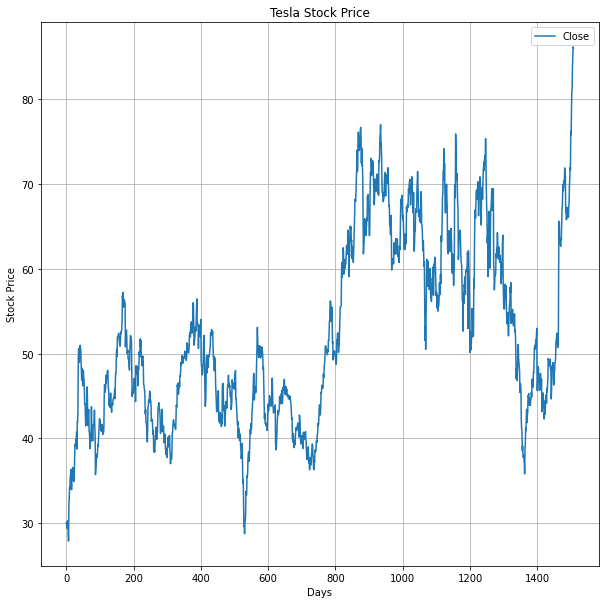

In [ ]:
# graph of Tesla stock price from 2014 to 2019 
plt.figure(figsize=(10,10))
plt.grid(True)
plt.plot(data, label = "Close")
plt.xlabel("Days")
plt.ylabel("Stock Price")
plt.title("Tesla Stock Price")
plt.legend()
plt.show()

##**Stage 1 : Initial Data Exploration**

We first analysed the dataset to see if there was a correlation between the observed price and prices appied with a lag as well as to see if we applied a difference to the data it could be made stationary

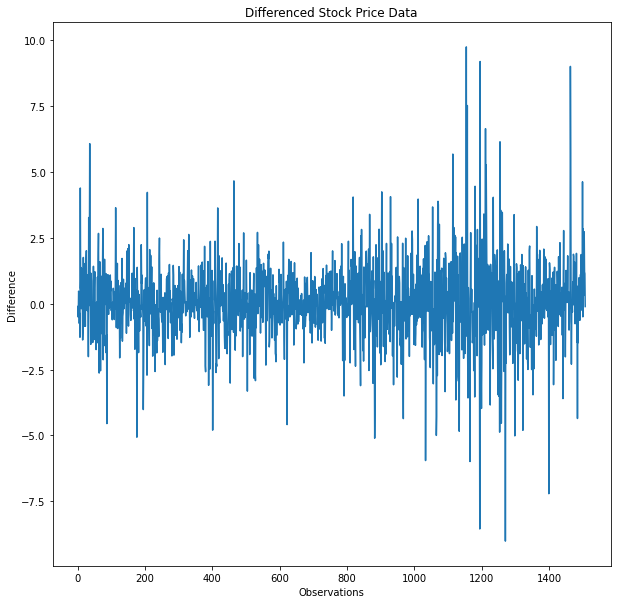

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Differenced Stock Price Data")
plt.xlabel("Observations")
plt.ylabel("Difference")
data_shift = data - data.shift(1)
plt.plot(data_shift)

In [ ]:
# applying DF test to the differenced data 
df_test = adfuller(data_shift.fillna(0))
print(df_test)

(-38.99099639584391, 0.0, 0, 1507, {'1%': -3.434696697851678, '5%': -2.8634597924260303, '10%': -2.567792072971565}, 5466.885372097506)


Applying a difference order of 1 has made the data more stationary with a given Ad-Fuller Test p-value of 0 


<Figure size 1440x1440 with 0 Axes>

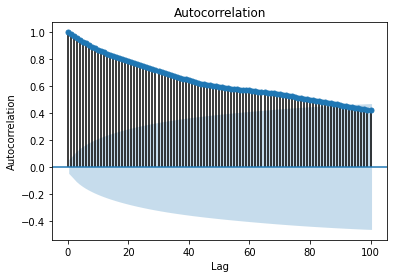

In [ ]:
plt.figure(figsize=(20,20))
plot_acf(data, lags=100)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

In [ ]:
plt.figure()
lag_plot(data, lag=1)
plt.title('TESLA Stock - Autocorrelation plot with lag = 1')
plt.show()

From the visualisations above, the optimal lagged series to use as a predictor variable would be 1 

##**Stage 2 : Building initial models**

After observing that there was a clear autocorrelation we built two autoregression models . The first being an ARIMA model 

In [ ]:
# training data is prices from 2014 start to end of 2018  
train = data.iloc[:1258].values
test = data.iloc[1258:].values

In [ ]:
history = [ x for x in train]
    # creating a list of all predictions 
predictions = list()
    # creating a list of absolute difference between true test value and predicted valued
residuals = list()
    # creating a rolling iteration of ARIMA to predict values given a 5 observation window
for t in range(len(test)):
      # creating a new model each iteration
  arima_model = ARIMA(history, order=(1,1,0))
  arima_model_fit = arima_model.fit(disp=0)
  output = arima_model_fit.forecast()
      # forecasting one value into the future
  yhat = output[0]
      # appending forecast to predictions list
  predictions.append(yhat)
      # appending testing data to historical data 
  obs = test[t]
  history.append(obs)
      # appending absolute residuals to residuals list 
  diff = np.abs(obs - yhat)
  residuals.append(diff)

Running the Model once resulted in the below visualisation

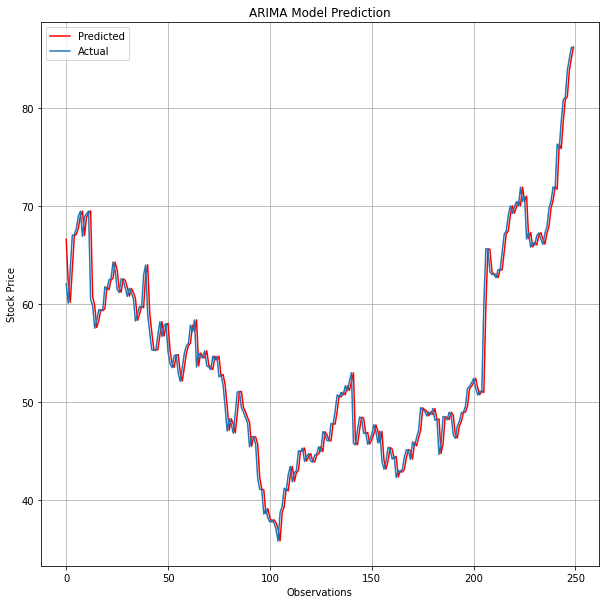

In [ ]:
# visualising the results
plt.figure(figsize=(10,10))
plt.grid(True)
plt.plot(predictions, color="red", label="Predicted")
plt.xlabel("Observations")
plt.ylabel("Stock Price")
plt.plot(test, label = "Actual")
plt.legend()
plt.title("ARIMA Model Prediction")
plt.show()

As a comparision measure, the absolute difference between the ARIMA prediction and the actual result was calculated for each observation, and the mean average was taken

Average Residual Error: 1.1547629355563542


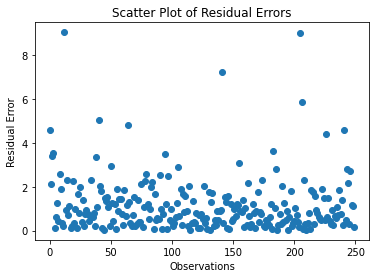

In [ ]:
plt.scatter(range(0,len(test)),residuals)
plt.title("Scatter Plot of Residual Errors for ARIMA")
plt.xlabel("Observations")
plt.ylabel("Residual Error")
print("Average Residual Error:" + " " + str(np.mean(residuals)))
plt.show()

We then built an LSTM Model 

In [ ]:
train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
train = sc.fit_transform(train)
test = sc.transform(test)

In [ ]:
X_train = []
y_train = []
for i in range(60, len(train)):
    X_train.append(train[i-60:i,0])
    y_train.append(train[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

The LSTM Model will use  4 hidden layers, the *adam* optimizer and using means squared error for the loss parameter and a dropout of 0.2 for each layer to reduce the risk of overfitting

In [ ]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
# fitting the model via 100 epochs and a batch size of 32
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

In [ ]:
#create the testing data sets
#create a new array containing scale values from index 1543 to 2003
data = np.array(data).reshape(-1,1)
scaled_data = sc.fit_transform(data)
test_data= scaled_data[len(train)-60:]
#create the data sets x_test and y_test
X_test = []
for i in range(60,len(test_data)):
    X_test.append(test_data[i-60:i])
#convert the data to a numpy array
X_test = np.array(X_test)
#reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_test.shape

(250, 60, 1)

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions = sc.inverse_transform(predictions)

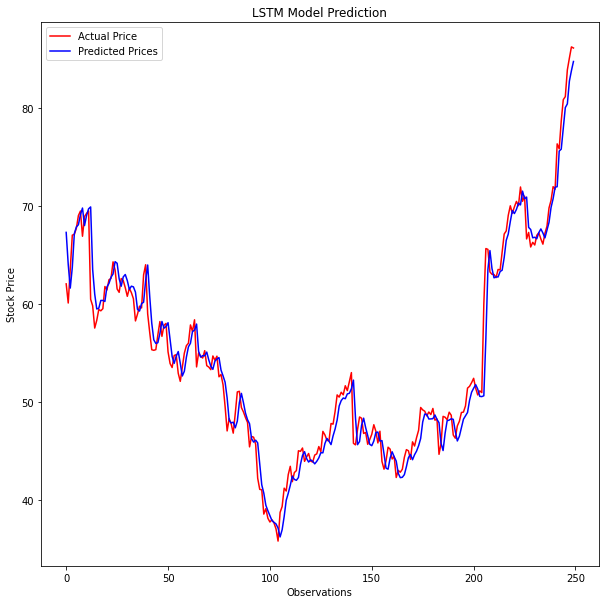

In [ ]:
plt.figure(figsize=(10,10))
plt.title("LSTM Model Prediction")
plt.xlabel("Observations")
plt.ylabel("Stock Price")
plt.plot(range(0,len(predictions)),data[1258:], color="red", label = "Actual Price")
plt.plot(range(0,len(predictions)),predictions, color="blue", label = "Predicted Prices")
plt.legend()
plt.show()

In [ ]:
residuals = []
for x in range(0,len(predictions)):
  diff = abs(predictions - data[1258:])
  residuals.append(diff)

Average Residual Error: 1.3570728759765625


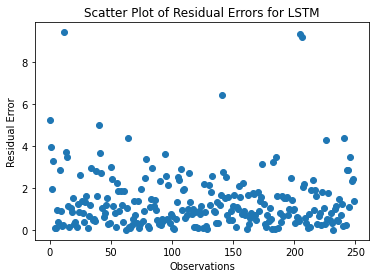

In [ ]:
plt.title("Scatter Plot of Residual Errors for LSTM")
plt.xlabel("Observations")
plt.ylabel("Residual Error")
plt.scatter(range(0,250),residuals[0])
print("Average Residual Error:" + " " + str(np.mean(residuals[0])))
plt.show()

##**An approach to multi-day forecasting**

The average residual error for the ARIMA model was smaller than when using the LSTM approach. However, both models are only forecasting one day into the future which is close to the average of the historic input values used. Thus, a true comparision would be to predict more than one day into the future

In [ ]:
# using ARIMA to forecast 5 days into the future 
# creating a list of all training observations 
history = [ x for x in train]
# creating a list of all predictions 
predictions = list()
# creating a list of absolute difference between true test value and predicted valued
residuals = list()
# creating a rolling iteration of ARIMA to predict values given a 5 observation window
for t in range(0,len(test),5):
  # creating a new model each iteration
  model = ARIMA(history, order=(5,1,0))
  model_fit = model.fit(disp=0)
  output = model_fit.forecast(steps = 5 )
  # forecasting one value into the future
  yhat = output[0]
  # appending forecast to predictions list
  predictions.append(yhat)
  # appending testing data to historical data 
  obs = test[t]
  history.append(obs)
  # appending absolute residuals to residuals list 
  diff = np.abs(obs - yhat)
  residuals.append(diff)

In [ ]:
predictions = np.array(predictions)
predictions = predictions.reshape(250,)

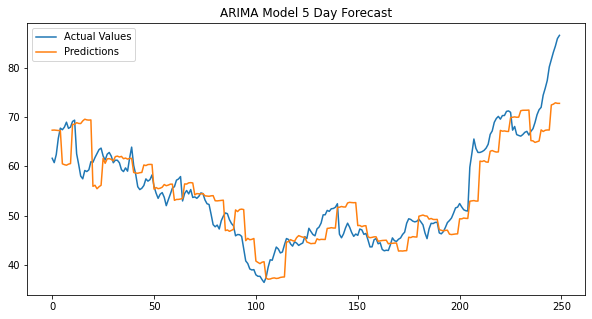

In [ ]:
plt.figure(figsize= (10,5))
plt.title("ARIMA Model 5 Day Forecast")
plt.plot(range(0,len(predictions)),prices["Midday"][1258:], label = "Actual Values")
plt.plot(predictions, label= "Predictions")
plt.xlabel("Observations")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

In [ ]:
print(" Average Residual Error:" + " " , np.mean(abs(predictions- prices["Midday"][1258:])))

 Average Residual Error:  3.6121131279590606


We can see that forecasting 5 days into the future gave a much higher Average Residual Error for the ARIMA model 

Next stage would be to use LSTM for the same 5 day forecasting

In [ ]:
# creating input data 
def Initial_Set(index):
  test_data= scaled_data[len(train)-60:]
  X_test = []
  y_test = scaled_data[len(train):]
  for i in range(60,len(test_data)):
      X_test.append(test_data[i-60:i])
  X_test = np.array(X_test)
  X_test.shape
  X_test = X_test[index]
  return X_test

In [ ]:
# using input data to create a multi day forecast 
def Multi_Forecast(length,index):
  X_test = Initial_Set(index)
  for x in range(0,length):
    X_test = np.reshape(X_test, (1,X_test.shape[0], 1))
    prediction = model.predict(X_test)
    X_test = X_test[0][1:]
    X_test = X_test.reshape((1,-1))
    X_test = np.concatenate((X_test[0], prediction[0]))
    predictions = X_test[-length:]
  return predictions

In [ ]:
# running Multi_Forecast function for 50 iterations 
predictions = []
for x in range(0,250,5):
  forecast = Multi_Forecast(5,x)
  predictions.append(forecast)

In [ ]:
predictions = np.array(predictions)

In [ ]:
predictions = sc.inverse_transform(predictions)

In [ ]:
predictions = predictions.reshape(-1,)

In [ ]:
start_predictions = predictions[::5]

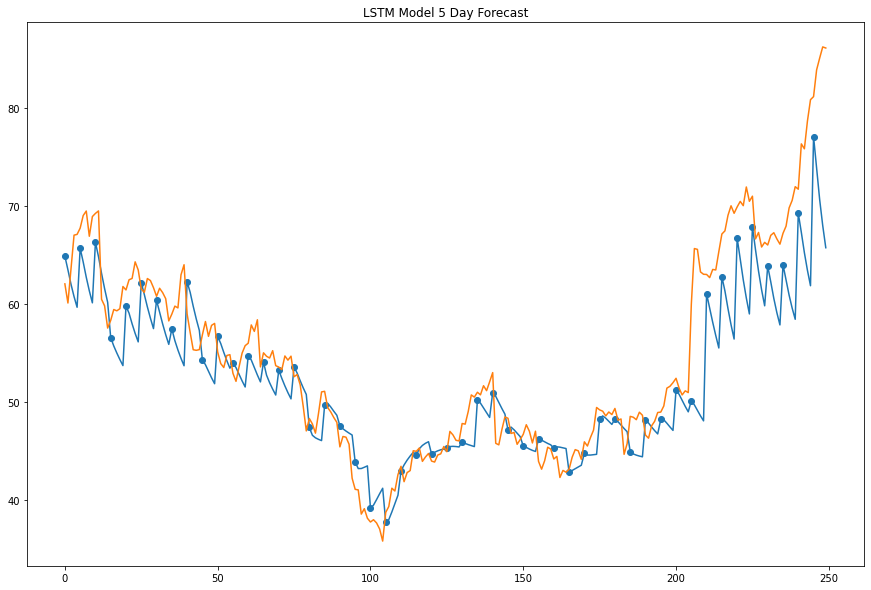

In [ ]:
plt.figure(figsize=(15,10))
plt.title("LSTM Model 5 Day Forecast")
plt.plot(predictions)
plt.plot(data[1258:])
plt.xlabel("Observation")
plt.ylabel("Stock Prices")
plt.scatter(range(0,250,5),start_predictions)

In [ ]:
print(" Average Residual Error:" + " " , np.mean(abs(predictions- data[1258:])))

 Average Residual Error:  10.208509330868347


Given the task of predicting 5 days into the future. The ARIMA model fails to give any price trend whereas the LSTMA model does. Even though the ARIMA model does have a lower Average Residual Error, the lack of trend makes it a less useful model in terms of multi-forecasting. 

##**Optimising ARIMA Hyperparameters**

We will use a grid search approach to finding the optimal ARIMA Hyperparameters. These being ,  ***d*** ,the difference order and  ***q***, the moving average order. ***p***, the lag value, was not an input into the the grid search due to time restraints but as p= 1 gave the highest autocorrelation we will assume the optimal parameter for "p" is 1 

In [ ]:
train = data.iloc[:1258].values
test = data.iloc[1258:].values

In [ ]:
def get_ARIMA(p,d,q):
  global train
  global test
  history = [ x for x in train]
  predictions = list()
  residuals = list()
  for t in range(len(test)):
    arima_model = ARIMA(history, order=(p,d,q))
    arima_model_fit = arima_model.fit(disp=0)
    output = arima_model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    diff = np.abs(obs - yhat)
    residuals.append(diff)
  return predictions, np.mean(residuals)

In [ ]:
iterations = [100]
differences = []
moving_average = []
for d in range(0,3):
  for q in range(0,3):
    try:
      error = get_ARIMA(1,d,q)[1]
      if error < min(iterations):
        iterations.append(error)
        differences.append(d)
        moving_average.append(q)
    except:
      pass

From the grid search, we concluded the optimal parameters for ARIMA was **( 1,1,0 )**

##**Conclusion**

We first saw that there was a high autocorrelation of tesla stock prices with it's lagged series. We then used ARIMA and LSTM to predict one day and 5 days into the future given an input of historical data. ARIMA gave a lower mean residual error than LSTM for both one day and 5 day forecasting, although the LSTM Model managed to give a higher degree of trend prediction for the 5 day forecasting. The LSTM approach is therefore more suited for long term forecasting. We then optimized the ARIMA Model in terms of it's difference order and moving average order. This managed to give a mean residual error of 1.155. 

Further investigations would include using another feature for the LSTM Model as well as an optimization of the LSTM hyperparameters to see if that would improve the performance of the LSTM model . As well, investigation of an ensemble approach using both models could also be conducted 
